# Some powerline can be disconnected, and there is ~~nothing~~ something you can do about it
Try me out interactively with: [![Binder](./img/badge_logo.svg)](https://mybinder.org/v2/gh/rte-france/Grid2Op/master)

To model the reality of powersystem operation and planning grid2op offer the possibility, when setting up an environment, to incldued powerline disconnection.

This is a really important part of power system decision process. Indeed, when a powerline is being built it is often for more than a few decades (in some TSO some equipements have been built and are still in service almost 100 years ago!). The **maintenance** of such equipements is then an important feature to model properly. In case of grid2op, the **maitnenance** is modeled as a disconnection of a powerline and the impossibility to reconnect it for a given amount of time. It is a planned operation for which you have some information in the observation:
- [`obs.time_next_maintenance`](https://grid2op.readthedocs.io/en/master/observation.html#grid2op.Observation.BaseObservation.time_next_maintenance) will give you, for each powerline, in how many time steps this powerline will be disconnected of the grid
- [`obs.duration_next_maintenance`](https://grid2op.readthedocs.io/en/master/observation.html#grid2op.Observation.BaseObservation.duration_next_maintenance) will give you, for each powerline, for how long (in number of time steps) this powerline will stay disconnected

On the other important property of the powergrid is that they cover large areas, usually they are the side of a whole country / state for example, counting hundred of thousands of "equipment" (varying in size from the tiny screws to fix two things together to wide transformers of the size of a building...). The probability, in these conditions, that any of this equipment fails is far from neglectable. For the record, the "failure" of an equipment have dozens of possible causes: it is in a bad shape (not enough maintenance), it suffers from an natural external aggression (wind storm, struck by lightning bolts, a tree falls on it, the external temperatur is too hot causing some thermal issues etc.) be the victim of malicious attack (a person hack a piece of software or physically attack the equipement with a bulldozer or a bombing for example) or it is not operated outside of its standard operation range (human error, bad data are send to the control center etc.) or any other cause you can imagine. Most of these phenomenon have a common consequence: one or more powerlines will be disconnected from the grid. This is what we call **hazards** in the grid2op framework. Compared to maintenance, **hazards** are not predictable (nothing, before it happens, indicates that there will be such hazards in the next few time steps).

Actually, in our framework, we also added the capability to explicitely model attacks on the grid. We call this feature **Opponent**. For now, we model the opponent as an entity that can take, at each time step, the decision to disconnect a powerline. It has the same effect as the **hazards** (you know what it will do before it is happening) but is different in the following sense:

- **hazards** will refer to random non predictable events (let's call it *natural failures*), they are, by essence, random
- **attack** (the action performed by an Opponent) will refer to possibly adversarial attacks, targeting equipement (not necessarily at random).


In both cases, you know when a **maintenance**, a **hazard** or an **attack** is happening if you look at the [`obs.time_before_cooldown_line`](https://grid2op.readthedocs.io/en/master/observation.html#grid2op.Observation.BaseObservation.time_before_cooldown_line) vector. It gives you, for each powerline, in how many time step at **minimum** you need to wait before being able to reconnect a powerline. If this is 0 you can change its status. If this > 0 you need to wait the appropriate number of time steps.

**NB** whether it's an attack, a hazard or a maintenance, the powerline will be automatically *disconnected*. They will stay *disconnected* until you reconnect them. This entails that if you don't reconnect them, they will remain disconnected.

# Handling maintenance

I think part we develop what are the effect of maintenances and how you can deal with them.

We start by loading an environment (here for test purpose) and reset it. We will study the powerline with id `56` because... why not. It is the line that goes from substations 26 to substation 30.

In [ ]:
import grid2op
from grid2op.PlotGrid import PlotMatplot
import numpy as np
env = grid2op.make("l2rpn_wcci_2020", difficulty="0", test=True)
plot_helper = PlotMatplot(env.observation_space)
env.seed(0)  # to get reproducible results
env.set_id(0)  # indicate to always read the same chronics, the first one
obs = env.reset()
do_nothing_action = env.action_space()
line_id = 56

In [ ]:
print("The powerline id {} will be in maintenance in {} time steps. This maintenance will last for {} "\
      "consecutive timesteps".format(line_id, obs.time_next_maintenance[line_id], obs.duration_next_maintenance[line_id]))

Let's now skip a few time steps and define some action usefull for the next cells.

In [ ]:
# first maintenance at 1260 (number of time step)
start_maintenance = 1259  

# define the action to reconnect it
reconnect_action = env.action_space({"set_line_status": [(line_id, +1)]})

# we skip a few time step, until the maintenance occur
env.fast_forward_chronics(start_maintenance)
# we get the observation at this very time steps
obs = env.get_obs()
print("Can i act on the powerline {}: {}".format(line_id, obs.time_before_cooldown_line[line_id] == 0))
print("Is the powerline connected: {}".format(obs.line_status[line_id]))
print("The powerline id {} will be in maintenance in {} time steps. This maintenance will last for {} "\
      "consecutive timesteps".format(line_id,
                                     obs.time_next_maintenance[line_id],
                                     obs.duration_next_maintenance[line_id]))
_ = plot_helper.plot_obs(obs)

As you see, just before the maintenance happened, the pwoerline is still connected (it is located in the top right corner of the graph, connect substation 26 to 30)

Now let's see what happen the first time timestep where the powerline is in maintenance:

In [ ]:
# one step pass
obs, reward, done, info = env.step(do_nothing_action)
print("Can i act on the powerline: {}".format(obs.time_before_cooldown_line[line_id] == 0))
print("In how many time I will be able to reconnect it: {}".format(obs.time_before_cooldown_line[line_id]))
print("Is the powerline connected: {}".format(obs.line_status[line_id]))
_ = plot_helper.plot_obs(obs)

And now Tadaaa ! you see that the powerline is disconnected automatically (the powerline is not dashed and black). By the way, this powerline disconnection has a pretty strong impact on the grid, as it causes the overload of 2 other powerlines showed here in red (the from connecting substation 26 to 28 and the one connected substation 28 to 31).

For academic purpose, let's see what is happening if i try to reconnect it.

In [ ]:
# let's try to reconnect the powerline
obs, reward, done, info = env.step(reconnect_action)
print("Can i act on the pwoerline: {}".format(obs.time_before_cooldown_line[line_id] == 0))
print("In how many time I will be able to reconnect it: {}".format(obs.time_before_cooldown_line[line_id]))
print("Is the powerline connected: {}".format(obs.line_status[line_id]))
_ = plot_helper.plot_obs(obs)

Unfortunately for us, this has absolutely no effect. The maintenance is still happening, the powerline status is locked until the maintenance is over (in 95 time steps)

Let's then do nothing for 95 remaining time step (I have to wait for 95 timesteps before i am able to reconnect it.)

In [ ]:
for _ in range(95):
    obs, reward, done, info = env.step(do_nothing_action)
print("Can i act on the powerline: {}".format(obs.time_before_cooldown_line[line_id] == 0))
print("In how many time I will be able to reconnect it: {}".format(obs.time_before_cooldown_line[line_id]))
print("Is the powerline connected: {}".format(obs.line_status[line_id]))
print("The flow on it is {:.1f}A (of course because it is switched off)".format(obs.a_or[line_id]))
_ = plot_helper.plot_obs(obs)

As you see, after the 95 time steps, the powerline can be reconnected (information printed), but that does not mean it is. Actually it is not reconnected until you do it. 

For example we can do a few more steps, and you will see the powerline still has not be reconnected.

In [ ]:
obs, reward, done, info = env.step(do_nothing_action)
_ = plot_helper.plot_obs(obs)

But now (we could have done that the preceeding time steps though) the powerline can be reconnected. Let us do it and see the resulting grid.

In [ ]:
# and now reconnect it
obs, reward, done, info = env.step(reconnect_action)
print("Can i act on the powerline: {}".format(obs.time_before_cooldown_line[line_id] == 0))
print("In how many time I will be able to reconnect it: {}".format(obs.time_before_cooldown_line[line_id]))
print("Is the powerline connected: {}".format(obs.line_status[line_id]))
print("The flow on it is {:.1f}A".format(obs.a_or[line_id]))
_ = plot_helper.plot_obs(obs)

**SUCCESS** the powerline has been properly reconnected, and everything on this part of the grid is now in order.

# Hazards / Opponent

In some settings

/home/benjamin/Documents/grid2op_dev/getting_started/grid2op/MakeEnv/Make.py:235: UserWarning:

You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.



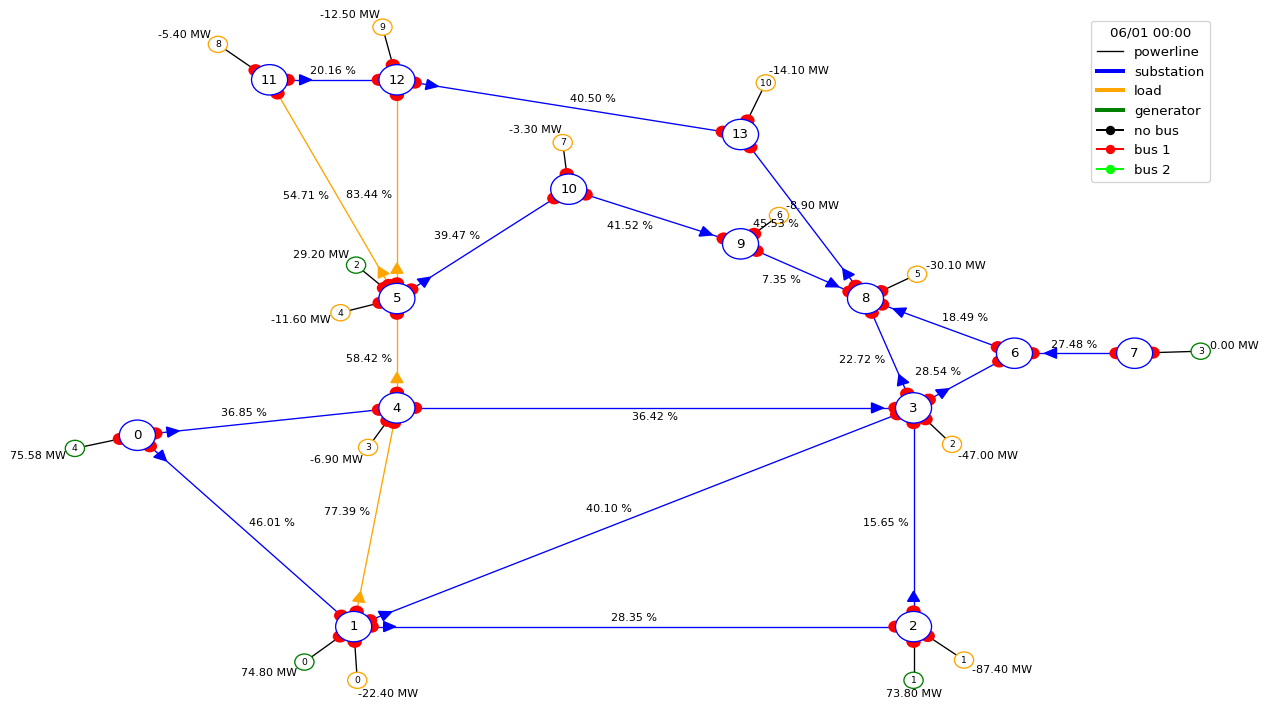

In [9]:
import numpy as np
import grid2op
from grid2op.PlotGrid import PlotMatplot
from grid2op.Parameters import Parameters
# i will disable the powerline disconnection in case of overflow
param = Parameters()
param.NO_OVERFLOW_DISCONNECTION = True
env_opp = grid2op.make("rte_case14_opponent", test=True, param=param)
plot_helper_opp = PlotMatplot(env_opp.observation_space)
line_id_opp = 3
reconnect_action_opp = env_opp.action_space({"set_line_status": [(line_id_opp, +1)]})
do_nothing_opp = env_opp.action_space()
env_opp.seed(0)  # make sure i have reproducible experiments
obs = env_opp.reset()
_ = plot_helper_opp.plot_obs(obs)

The next maintenance is schedule in -1 time steps (-1 = never)


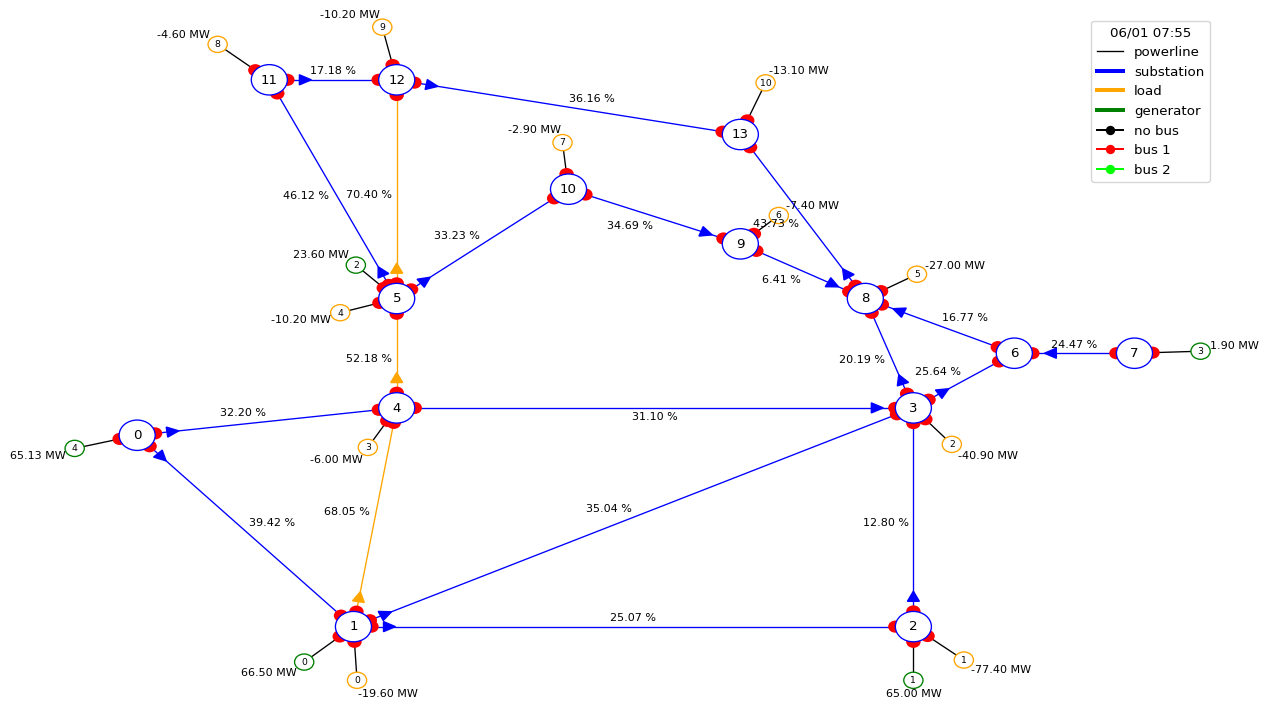

In [10]:
for i in range(95):
    obs, reward, done, info = env_opp.step(do_nothing_opp)
print("The next maintenance is schedule in {} time steps (-1 = never)"\
      "".format(obs.time_next_maintenance[line_id_opp]))
_ = plot_helper_opp.plot_obs(obs)

Now let's do another step, note that not maintenance are planned for the forseeable future.

The next maintenance is schedule in -1 time steps (-1 = never)
The flow on this powerline is 0.0
This powerline is unavailable for 47 time steps


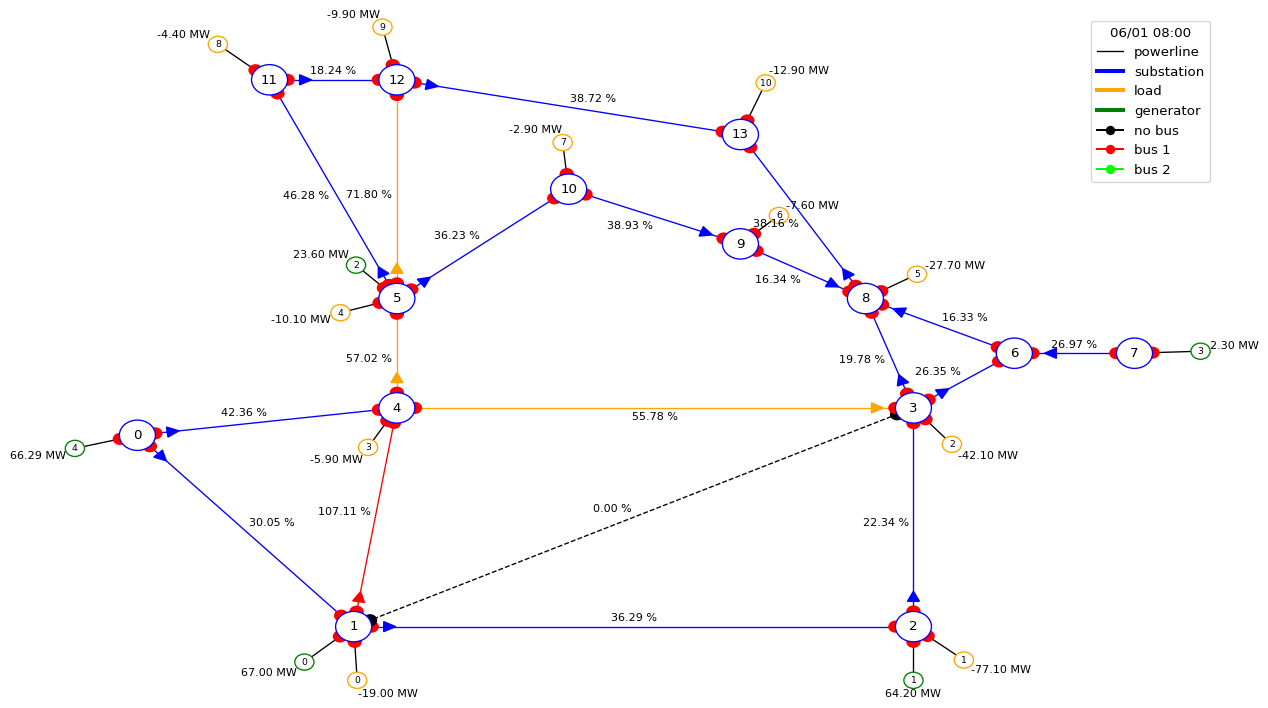

In [11]:
obs, reward, done, info = env_opp.step(do_nothing_opp)
_ = plot_helper_opp.plot_obs(obs)
print("The next maintenance is schedule in {} time steps (-1 = never)"\
      "".format(obs.time_next_maintenance[line_id_opp]))
print("The flow on this powerline is {}"\
      "".format(obs.rho[line_id_opp]))
print("This powerline is unavailable for {} time steps".format(obs.time_before_cooldown_line[line_id_opp]))

We have been victim of an "attack" on the grid. The powerline 3, connecting substation 1 to substation 3 is now out of service for 47 time steps. As it was the case for maintenance, any attempt to reconnect it will fail.

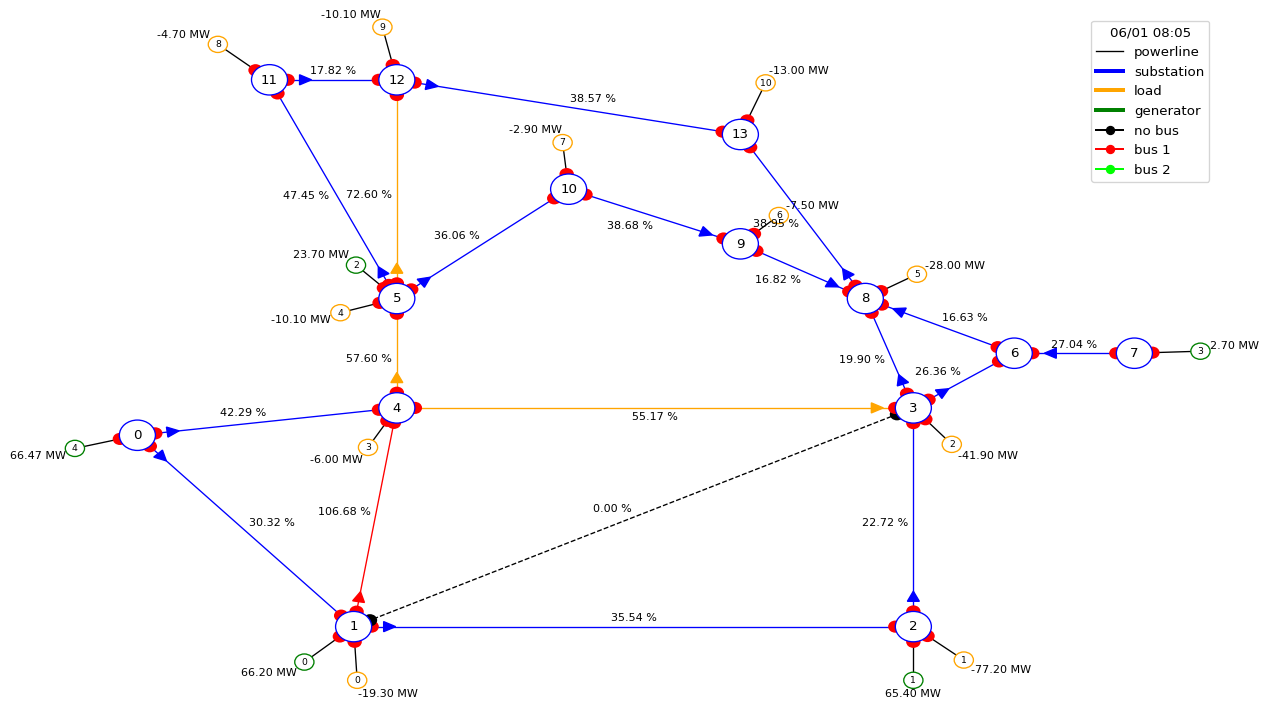

In [12]:
obs, reward, done, info = env_opp.step(reconnect_action_opp)
_ = plot_helper_opp.plot_obs(obs)